# Spin echo simulation

This simulation aims to implement a functional simulation of the [spin echo phenomenon](https://en.wikipedia.org/wiki/Spin_echo). The approach used here is by the analytical function that describes the evolution of a proton's population magnetization in the x direction under a magnetic field after suffering a RF pulse:

$$M_x(t) = M_0 e^{i(\omega t + \phi)}$$

![Simulation of the spin echo](https://upload.wikimedia.org/wikipedia/commons/9/9b/HahnEcho_GWM.gif)

**Altough it may seem obvious, it is important to remember that the flip is around the longitudinal (z direcion), and not a phase of $\pi$ to the spin!**

## Libraries
The cells below include libraries that will be useful in the process of the simulation.

In [19]:
import matplotlib.pyplot as plt
import numpy as np

## Functions
The cells below denote functions that will be useful for the simulation.

In [32]:
def normalize(vec : np.ndarray) -> np.ndarray:
  """Normalizes an array or a set of arrays.

  Parameters
  ----------
  vec : np.ndarray (N, M)
    Array to be normalized."""
  return vec/np.tile(np.linalg.norm(vec, axis = 0), vec.shape[0]).reshape(vec.shape)

def single_transverse_decay(t : np.ndarray, T2 : float,  M_0: float, w : float, phi : float):
    """Simulates the transverse decay of the magnetization of a single spin.
    
    Parameters
    ----------
    t : np.ndarray (N, 1)
      Time array of the simulation.
    T2 : float
      Decaying time of the transverse magnetization.
    M_0 : float
      Initial magnetization constant.
    w : float
      Frequency of precession of the spin.
    phi : float
      Phase of the magnetization.
    """
    return M_0*np.exp( 1j*(w*t + phi) )*np.exp(-t/T2)

def population_transverse_decay(t0 : float, tn : float, dt : float, T2 : np.ndarray, M_0: float, w : np.ndarray, phi : np.ndarray, echo : np.ndarray):
  """Simulates the transverse decay of the magnetization of a population of spins.

  Parameters
    ----------
    t0 : float
      Initial time of the simulation.
    tn : float
      Final time of the simulation.
    dt : float
      Time step of the simulation.
    T2 : np.ndarray (N, 1)
      Decaying times of the transverse magnetizations of each spin.
    M_0 : float
      Initial magnetization constant.
    w : np.ndarray (N, 1)
      Frequencies of precession of the spins.
    phi : float
      Phases of the magnetization of each spin.
    echo : np.ndarray (M, 1)
      Echoes times to be applied to the simulation."""
  n = T2.shape[0]

  S = np.array([])
   
  ts = np.concatenate((np.array([t0]), echo, np.array([tn])))

  acc_phi = np.copy(phi)

  for k in range(ts.shape[0] - 1):
    t = np.arange(ts[k], ts[k + 1], dt)
    Dt = ts[k + 1] - t0
    S0 = np.zeros_like(t)

    for i in range(n):
      S0 += single_transverse_decay(t, T2[i], M_0, w[i], acc_phi[i]).real
      theta = w[i]*Dt
      acc_phi[i] += np.pi - 2*theta - 2*acc_phi[i]
      
    S = np.concatenate((S, S0))

  return S, np.arange(t0, tn, dt) 


def rerange(img : np.ndarray, min = 0.0, max = 1.0):
  """Function that converts an image to the given desired range.
  
  Parameters
  ----------

  img : np.ndarray
    Image to be normalized.
  min : float
    Bottom value of the new range for conversion.
  max : float
    Top value of the new range for conversion."""
  return ((img - np.min(img))/(np.max(img) - np.min(img)))*(max - min) + min

## Simulation

First, the time parameters of the simulation are defined:

In [21]:
t0 = 0.0
TE = 300.0
dt = 0.001

t = np.arange(t0, TE/2, dt)


print("The maximum frequency that can be captured here is:", ((TE - t0)/dt)/2.0, "Hz")

The maximum frequency that can be captured here is: 150000.0 Hz


Above it is possible to verify the maximum frequency that can be captured by this sampling, according to the [Nyquist rate](https://en.wikipedia.org/wiki/Nyquist_rate). Then, the simulation parameters should be set. Below, we define:

1. $B_0$ 
2. $\gamma$ 
3. $w_0$
4. The number of spins $n$
5. The maximum variation of the precession frequency $w_0$, $epsilon$

In [22]:
B0 = 1.0
gamma = 10.00
w0 = gamma*B0
n = 500
epsilon = 0.1

At last, each spin is "generated". Below, we define everyone's frequency of precession:

In [23]:
T2s = np.full(n, 500.0) 

ws = rerange(np.random.rand(n), -epsilon, epsilon) + w0

print("The maximum frequency that exists here is:", np.max(ws), "Hz")
print("The maximum frequency will be captured!" if np.max(ws) <= ((TE - t0)/dt)/2.0 else "The maximum frequency will NOT be captured!")

The maximum frequency that exists here is: 10.1 Hz
The maximum frequency will be captured!


Finally, the simulation can be ran. First the transverse decay before

In [24]:
S_0 = 0.0

for i in range(n):
    S_0 += single_transverse_decay(t, T2s[i], 1.0, ws[i], 0.0).real

Text(0, 0.5, 'Magnetization (u.a.)')

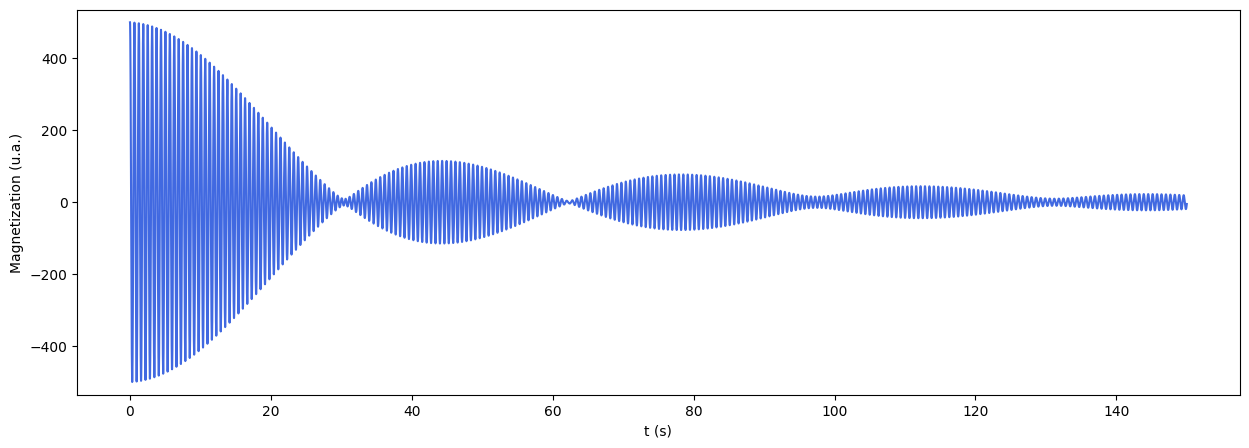

In [25]:
plt.figure(figsize = (15, 5))

plt.plot(t, S_0, c = "royalblue")
plt.ylim(-(n + n*0.07), n + n*0.07)
plt.xlabel("t (s)")
plt.ylabel("Magnetization (u.a.)")

The flip is then applied to the spins. Here, the flip is applied mirrowing around the longitudinal direction. To do that, a phase of $\pi - 2\theta_i$ should be applied, with $\theta_i$ being the phase acquired by the spin after moving $\omega_i \Delta t$ radians, as it is shown below:

![Phase to be applied to the flip](phase.jpeg)

In [26]:
t1 = np.arange(TE/2, 1.5*TE, dt)
new_t0 = t1[0]
t1 = t1[1:]

S_1 = 0.0

for i in range(n):
    phi = ws[i]*(new_t0 - t0)
    S_1 += single_transverse_decay(t1, T2s[i], 1.0, ws[i], np.pi - 2*phi ).real



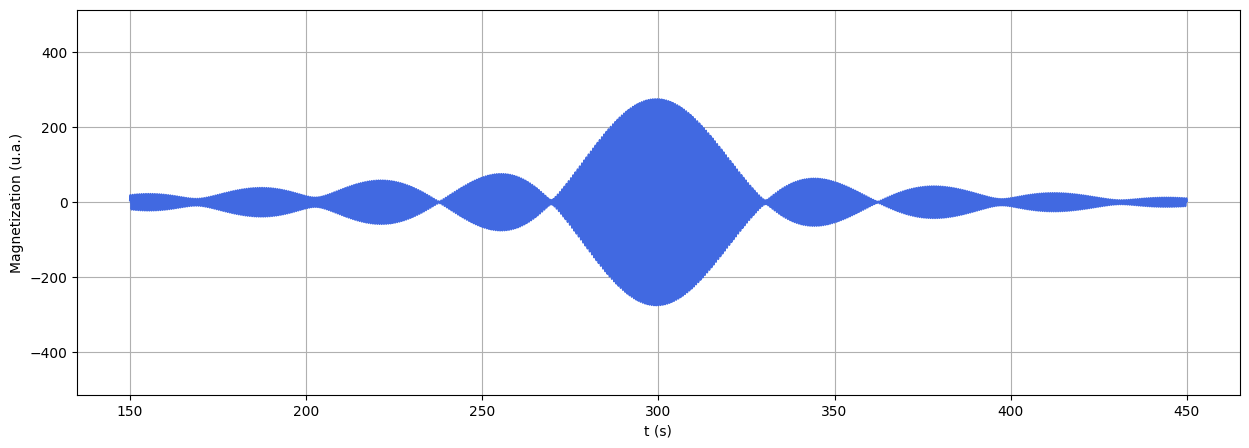

In [27]:
plt.figure(figsize = (15, 5))
plt.plot(t1, S_1, c = "royalblue")
plt.ylim(-n - 0.025*n, n + 0.025*n)
plt.xlabel("t (s)")
plt.ylabel("Magnetization (u.a.)")
plt.grid()

As it can be seen above, the echo was successfully generated. Below, the full simulation:

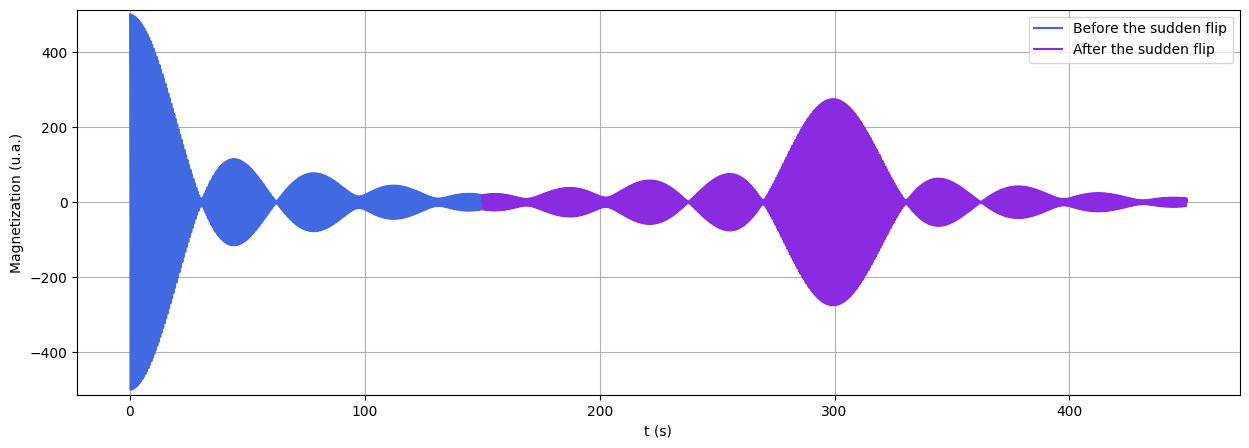

In [28]:
plt.figure(figsize = (15, 5))
plt.plot(t, S_0, label = "Before the sudden flip", c = "royalblue")
plt.plot(t1, S_1, label = "After the sudden flip", c = "blueviolet")
plt.ylim(-n - 0.025*n, n + 0.025*n)
plt.xlabel("t (s)")
plt.ylabel("Magnetization (u.a.)")
plt.legend()
plt.grid()

Now, moduling the above functions into a general one:

In [29]:
phis = np.zeros(n)

t0 = 0.0
tn = 1000.0

echos = np.array([150.0, 500.0])

S, t = population_transverse_decay(0.0, 1000.0, dt, T2s, 1.0, ws, phis, echos)

[500.         499.97399692 499.8979904  ...  -5.28217257  -5.09970663
  -4.91675547]
[500.         499.97399692 499.8979904  ...   2.70200638   2.72386089
   2.74545344]
[500.         499.97399692 499.8979904  ...   3.377852     3.36522534
   3.35226162]


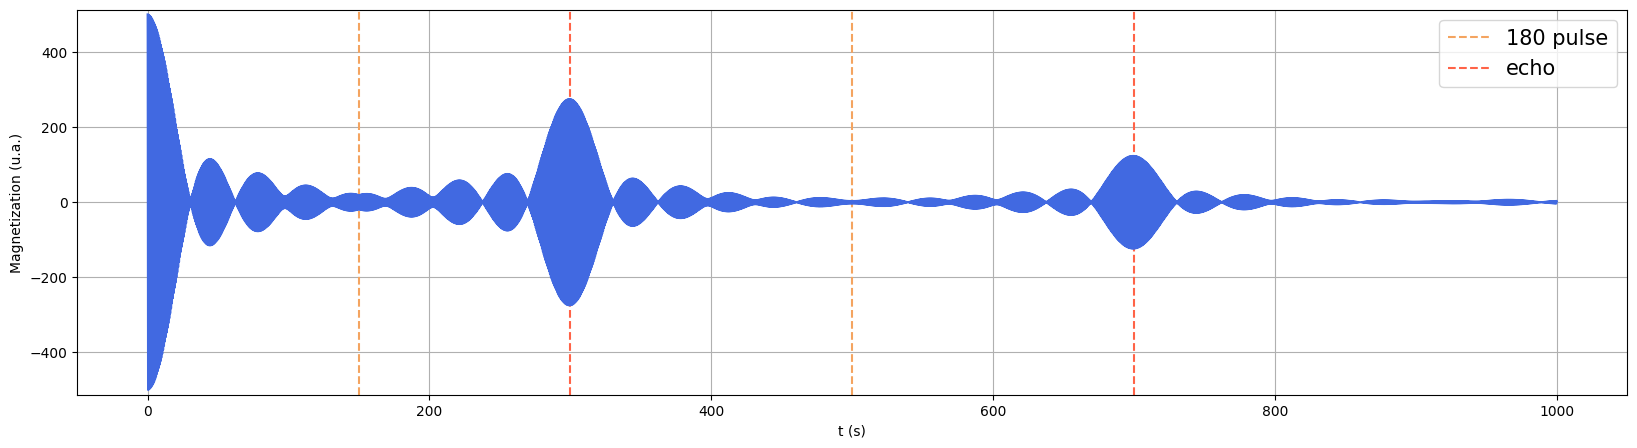

In [31]:

s0, sn = np.where(t == t0)[0][0], np.where(t == tn - dt)[0][0] 

echos_lines = np.zeros_like(echos)
echos_lines[0] = 2*echos[0]
for i in range(1, echos.shape[0]):
    echos_lines[i] = (2*echos[i] - echos_lines[i-1])*int(i != 1) + 2*(echos[i] - echos[i-1])*int(i == 1)

plt.figure(figsize=(20, 5))
plt.vlines(echos, -n - 0.025*n, n + 0.025*n, colors="sandybrown", linestyles= "dashed", label="180 pulse")
plt.vlines(echos_lines, -n - 0.025*n, n + 0.025*n, colors="tomato", linestyles= "dashed", label="echo")
plt.plot(t[s0:sn], S[s0:sn], c = "royalblue")
plt.ylim(-n - 0.025*n, n + 0.025*n)
plt.xlabel("t (s)")
plt.ylabel("Magnetization (u.a.)")
plt.grid()
plt.legend(fontsize = 15)